In [1]:
import pertpy as pt
import scanpy as sc

import random
import numpy as np
import torch
import os
import sklearn
import scipy
from sklearn.neighbors import NearestNeighbors

def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWar

In [2]:
def mixscape(adata,obs_label, ref_label, expr_label, nn=20, return_te = True):
    sc.pp.pca(adata)
    X_pca1 = adata.obsm['X_pca'][adata.obs[obs_label]==expr_label,:]
    X_pca2 = adata.obsm['X_pca'][adata.obs[obs_label]==ref_label,:]
    nbrs = NearestNeighbors(n_neighbors=nn, algorithm='ball_tree').fit(X_pca1)
    mixscape_pca = adata.obsm['X_pca'].copy()
    mixscapematrix = nbrs.kneighbors_graph(X_pca2).toarray()
    mixscape_pca[adata.obs[obs_label]==ref_label,:] = np.dot(mixscapematrix, mixscape_pca[adata.obs[obs_label]==expr_label,:])/20
    if return_te:
        te2 = adata.X[adata.obs[obs_label]==ref_label,:] - (mixscapematrix/np.sum(mixscapematrix,axis=1)[:,None]) @ (adata.X[adata.obs[obs_label]==expr_label,:])
        return mixscape_pca, mixscapematrix, te2
    else:
        return mixscape_pca, mixscapematrix

def run_mixscape(adata, condition_key, cell_type_key, exp_label, ref_label, dataset_name):
    if isinstance(adata.X, scipy.sparse.spmatrix):
        adata.X = adata.X.toarray()

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)
    '''
    ms = pt.tl.Mixscape()

    ms.perturbation_signature(
        adata_,
        pert_key=condition_key,
        control=ref_label,
        split_by=None,
        n_neighbors=20,
    )
    '''
    mixscape_pca, mixscapematrix=mixscape(adata=adata,obs_label=condition_key, ref_label=ref_label, expr_label=exp_label, nn=20, return_te = False)

    adata_.obsm["ef"] = np.array(mixscape_pca)#(adata_.layers["X_pert"])
    sc.pp.neighbors(adata_, use_rep="ef")

    sc.tl.umap(adata_, random_state=1)
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)

    adata_.write("./mixscape/"+dataset_name+".h5ad")
    
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    try:
        import warnings
        warnings.filterwarnings("ignore")
        warnings.filterwarnings("ignore", category=FutureWarning)
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='ef', savepath="./mixscape/"+dataset_name+".csv")
    except:
        import warnings
        warnings.filterwarnings("ignore")
        warnings.filterwarnings("ignore", category=FutureWarning)
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='ef', savepath="./mixscape/"+dataset_name+".csv")

# PBMC

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583

https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


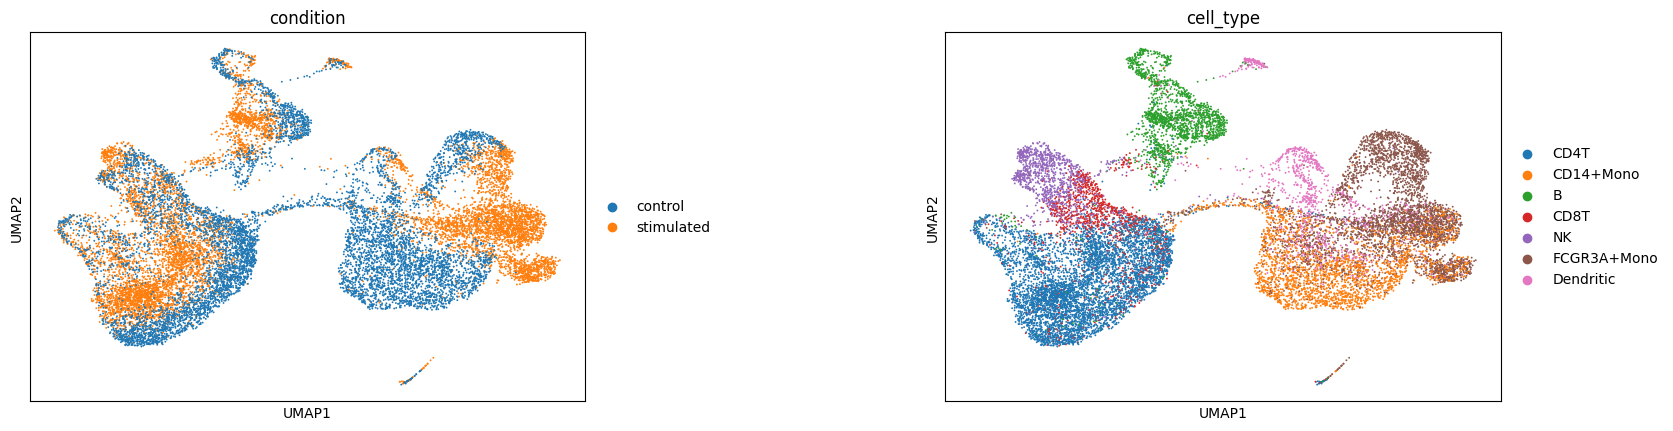

['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---
cLISI, bLISI, LISI_F1 0.9372634050033508 0.15535015079570502 0.2665242629102888
ASW---
asw_label 0.5397426709532738
asw_batch 0.7102150349278984
kBET---
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC.h5ad')
run_mixscape(adata=adata, condition_key='condition', cell_type_key='cell_type', exp_label='stimulated', ref_label='control', dataset_name="PBMC")

# PBMC (yale)

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

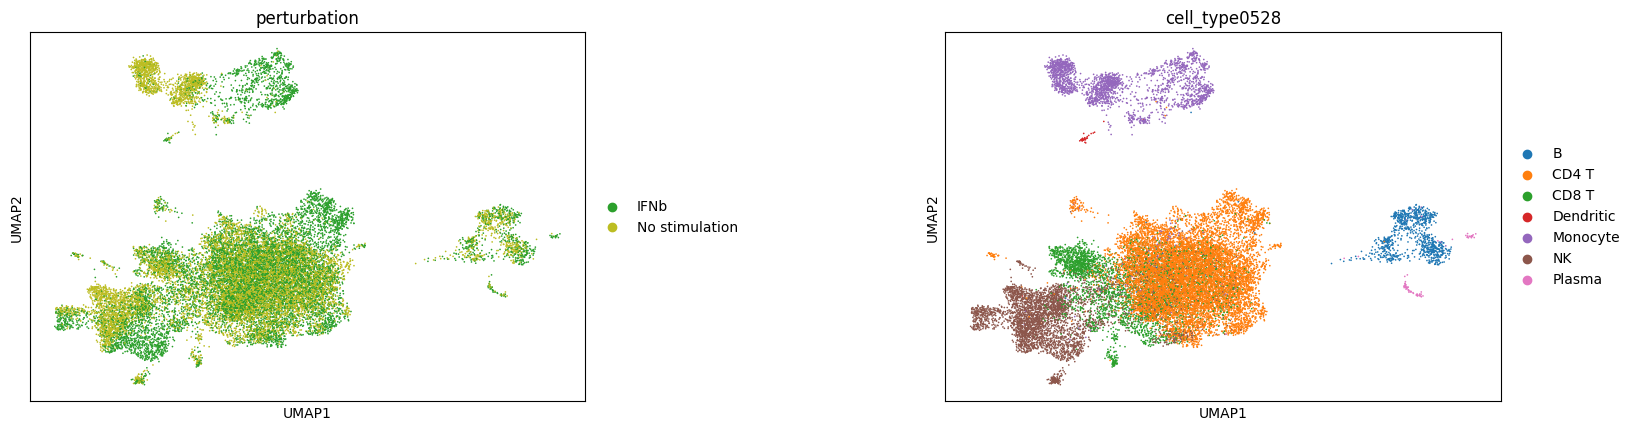

['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---
cLISI, bLISI, LISI_F1 0.9746267380165559 0.32091405194293704 0.4828430228562693
ASW---
asw_label 0.5324309840798378
asw_batch 0.9326551417585405
kBET---
0 labels consist of a single batch or is too small. Skip.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')
run_mixscape(adata=adata, condition_key='perturbation', cell_type_key='cell_type0528', exp_label='IFNb', ref_label='No stimulation', dataset_name="PBMC_yale")

# The Rhinovirus infection dataset

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

In [ ]:
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["condition"]=adata.obs["batch"].copy()
run_mixscape(adata=adata, condition_key='condition', cell_type_key="cell_type1021", exp_label='CSE', ref_label='MOCK', dataset_name="virus")

# (EC)CITE-seq

https://www.nature.com/articles/s41588-021-00778-2

In [ ]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
run_mixscape(adata=adata, condition_key='perturbation', cell_type_key="Phase", exp_label='NT', ref_label='Perturbed', dataset_name="ECCITE")

# ASD

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

In [ ]:
adata=sc.read_h5ad("../data/ASD.h5ad")
run_mixscape(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD")